In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

src_path = os.path.abspath(os.path.join(os.getcwd(), 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils import create_sliding_windows, SequentialDeepONetDataset
from s_deeponet import SequentialDeepONet

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Dataset

In [4]:
# Target scaler values [min, max]
target_min = 0.02640343
target_max = 0.03839979

target_scaler = [target_min, target_max]

# trunk
trunk = np.load('data/grid_points.npy')

print(trunk[:,0].min(), trunk[:,0].max())
print(trunk[:,1].min(), trunk[:,1].max())

# Normalize trunk input
trunk[:, 0] = (trunk[:, 0] - np.min(trunk[:, 0])) / (np.max(trunk[:, 0]) - np.min(trunk[:, 0]))
trunk[:, 1] = (trunk[:, 1] - np.min(trunk[:, 1])) / (np.max(trunk[:, 1]) - np.min(trunk[:, 1]))

-90.0 90.0
-180.0 180.0


In [5]:
# Load the sensor data
test_input = np.load('data/test_data.npz')['test_input']
test_target = np.load('data/test_data.npz')['test_target']

In [6]:
# Generate sequences for the testing set
test_input_seq, test_target_seq = create_sliding_windows(test_input, test_target, window_size=7)

In [7]:
test_dataset = SequentialDeepONetDataset(test_input_seq, trunk, test_target_seq)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# model initialization

In [8]:
def init_model():
    dim = 128
    model = SequentialDeepONet(
        branch_type='lstm',
        branch_input_size=12,
        branch_hidden_size=128,
        branch_num_layers=4,
        branch_output_size=dim,
        trunk_architecture=[2, 128, 128, dim],
        num_outputs=1,
        use_transform=False,
        activation_fn=nn.ReLU,
    )
    return model

In [9]:
# pre-trained model path
save_path = os.path.join('single_branch', 'lstm_window_7.pth')

model = init_model()
#model.load_state_dict(torch.load(save_path, map_location='cpu'))
model.load_state_dict(torch.load(save_path))

model.to(device)

model.eval()

SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)

### Prediction

In [10]:
# create new points
# Define the grid resolution (2.5 degrees)
grid_step = 0.25

# Generate arrays for longitudes and latitudes
longitudes = np.arange(-180, 180 + grid_step, grid_step)  # From -180 to 180
latitudes = np.arange(-90, 90 + grid_step, grid_step)     # From -90 to 90

# Create a meshgrid for all pairs of (lon, lat) values
lon_grid, lat_grid = np.meshgrid(latitudes, longitudes)

# Flatten the arrays to list all the corner points as pairs
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Combine longitudes and latitudes into pairs of grid points
grid_array = np.column_stack((lon_flat, lat_flat))

x = grid_array[:, 0]
y = grid_array[:, 1]

# Normalize the grid points
x = (x - np.min(x)) / (np.max(x) - np.min(x))
y = (y - np.min(y)) / (np.max(y) - np.min(y))
# Combine the normalized x and y into a single array
grid_points = np.column_stack((x, y))

print(grid_points.shape)

(1038961, 2)


In [11]:
test_dataset = SequentialDeepONetDataset(test_input_seq, grid_points, test_target_seq)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

all_outputs = []
all_targets = []

model.eval()
with torch.no_grad():
    for branch_batch, trunk_batch, target_batch in test_loader:
        branch_batch, trunk_batch, target_batch = (
            branch_batch.to(device),
            trunk_batch.to(device),
            target_batch.to(device),
        )
        output = model(branch_batch, trunk_batch)
        
        all_outputs.append(output.cpu())
        all_targets.append(target_batch.cpu())

# After loop:
outputs = torch.cat(all_outputs, dim=0)  # [N_test, output_dim]
targets = torch.cat(all_targets, dim=0)  # [N_test, output_dim]

# revese the normalization of outputs
#target_min = 0.02640343
#target_max = 0.03839979

outputs = outputs.numpy()
outputs = outputs * (target_max - target_min) + target_min

In [12]:
def convert2dim(dose_array):
    # laod the grid_array
    #grid_array = np.load('data/grid_points.npy')
    #grid_array = grid_array

    # Sort grid_array by latitude first (column 0), then by longitude (column 1)
    sorted_indices = np.lexsort((grid_array[:, 1], grid_array[:, 0]))
    sorted_grid_array = grid_array[sorted_indices]
    sorted_dose_array = dose_array[sorted_indices]
    
    # Extract unique latitude and longitude values from the sorted grid array
    latitudes = np.unique(sorted_grid_array[:, 0])  # Extract unique latitude values (y-axis)
    longitudes = np.unique(sorted_grid_array[:, 1])  # Extract unique longitude values (x-axis)

    # Create a meshgrid with (longitude, latitude) to match the correct order
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # Ensure the sorted dose_array is reshaped correctly to match the meshgrid dimensions
    z = sorted_dose_array.reshape(len(latitudes), len(longitudes))
    
    return lon_grid, lat_grid, z

In [13]:
# get and transform
# convert the preds and targets to 2D
preds_2d = []
targets_2d = []
for i in range(len(outputs)):
    pred_2d = convert2dim(outputs[i])
    #target_2d = convert2dim(targets[i])
    preds_2d.append(pred_2d)
    #targets_2d.append(target_2d)
    
# convert to numpy array
preds_2d = np.array(preds_2d)
#targets_2d = np.array(targets_2d)

print(preds_2d.shape)

(359, 3, 721, 1441)


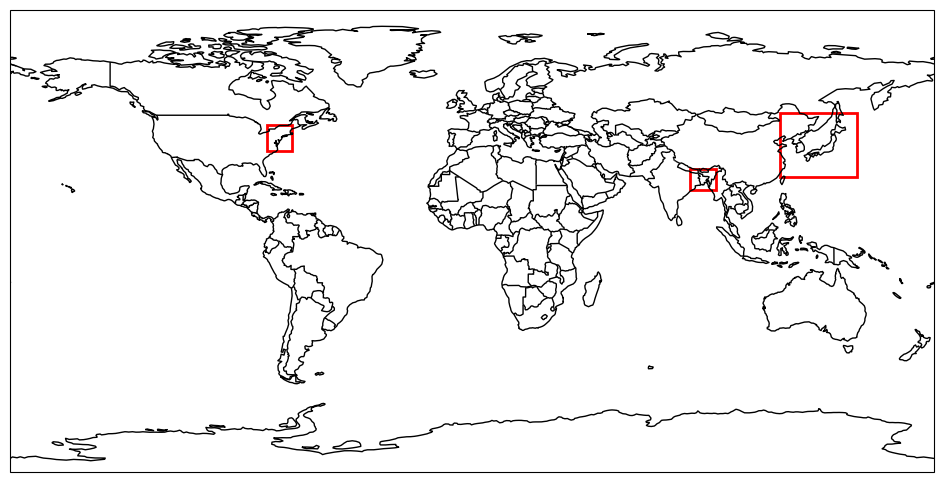

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches

# Create figure and axis
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))

# --- Map features ---
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# --- Set full extent ---
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# --- Define regions (only xlim and ylim) ---
regions = [
    {'xlim': (85, 95), 'ylim': (20, 28)},    # Bangladesh
    {'xlim': (120, 150), 'ylim': (25, 50)},  # Japan
    {'xlim': (-80, -70), 'ylim': (35, 45)}   # New York
]

# --- Draw rectangles without names ---
for region in regions:
    x0, x1 = region['xlim']
    y0, y1 = region['ylim']
    
    rect = patches.Rectangle(
        (x0, y0), x1 - x0, y1 - y0,
        linewidth=2, edgecolor='red', facecolor='none',
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)

plt.show()


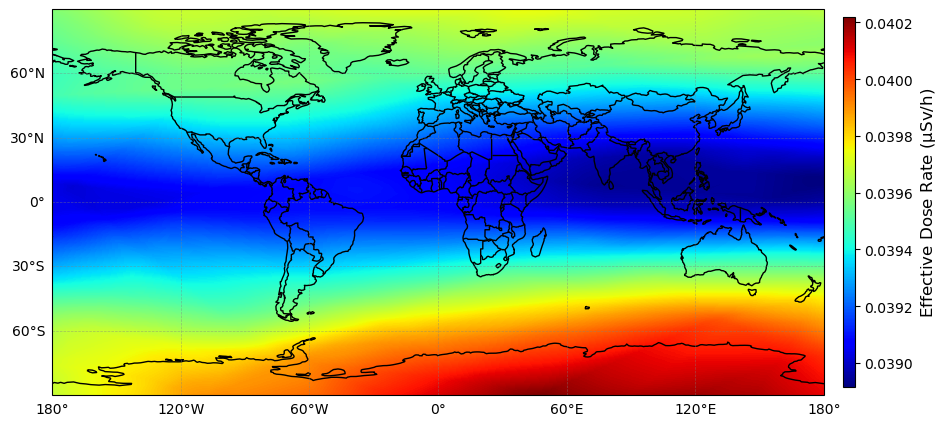

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assume you want to plot timestep 0
timestep = 0

# Unpack your prediction data
lon = preds_2d[timestep][0]  # Shape (361, 721)
lat = preds_2d[timestep][1]
prediction = preds_2d[timestep][2]

# Create figure and axis
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))

# --- Plot the prediction field ---
im = ax.pcolormesh(
    lon, lat, prediction,
    cmap='jet',
    shading='auto',  # <-- This ensures smooth shading
    transform=ccrs.PlateCarree()
)

# --- Map features ---
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# --- Set extent ---
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# --- Gridlines ---
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# --- Add colorbar ---
cbar = plt.colorbar(
    im, ax=ax,
    orientation='vertical',
    pad=0.02,
    aspect=30,
    shrink=0.8
)
cbar.set_label(r'Effective Dose Rate ($\rm \mu Sv/h$)', fontsize=12)

# --- Show plot ---
plt.show()


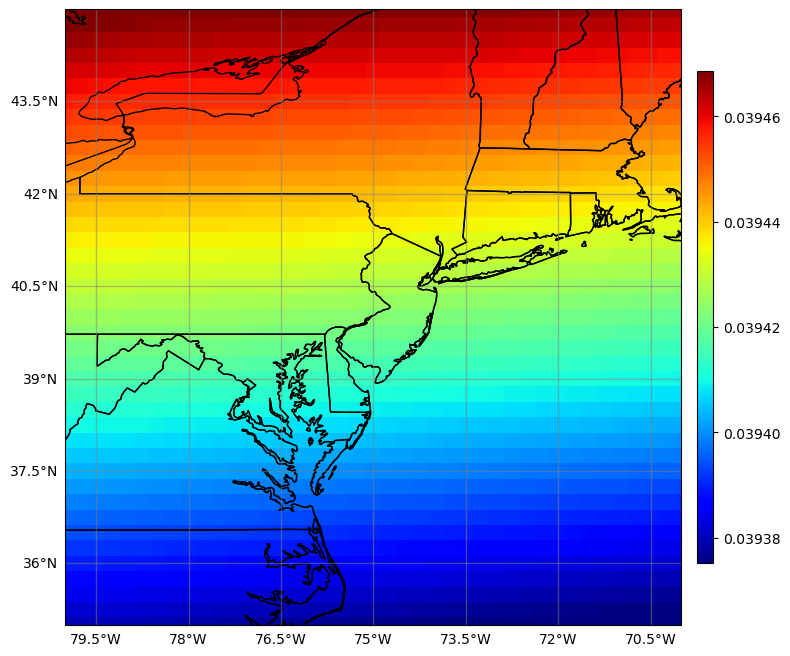

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assume you want to plot timestep 0
timestep = 0

lon = preds_2d[timestep][0]
lat = preds_2d[timestep][1]
prediction = preds_2d[timestep][2]

# Define zoom window
# Bangladesh
#xlim = (85, 95)
#ylim = (20, 28)

# Japan
#xlim = (120, 150)
#ylim = (25, 50)

# NY
xlim = (-80, -70)
ylim = (35, 45)

# Create a mask for the zoomed-in region
mask = (lon >= xlim[0]) & (lon <= xlim[1]) & (lat >= ylim[0]) & (lat <= ylim[1])

# Extract prediction values only in the zoomed window
visible_prediction = prediction[mask]

# Calculate colorbar limits from zoomed window
vmin, vmax = np.percentile(visible_prediction, [1, 99])

# --- Plot ---
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))

# Use pcolormesh
im = ax.pcolormesh(
    lon, lat, prediction,
    cmap='jet',
    shading='auto',   # very important for smoothness
    transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax
)

# Add map features
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# new york
#ax.add_feature(cfeature.LAKES, edgecolor='black')
#ax.add_feature(cfeature.RIVERS, edgecolor='black')
ax.add_feature(cfeature.STATES, edgecolor='black')

# Zoom to region
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# --- Correct colorbar ---
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=30, shrink=0.8)
#cbar.set_label(r'Effective Dose Rate ($\rm \mu Sv/h$)', fontsize=12)

# Show the figure
plt.show()


In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import datetime

def animation():
    # Calculate vmin/vmax from zoomed region (first frame)
    lon = preds_2d[0][0]
    lat = preds_2d[0][1]
    prediction = preds_2d[0][2]

    mask = (lon >= xlim[0]) & (lon <= xlim[1]) & (lat >= ylim[0]) & (lat <= ylim[1])
    visible_prediction = prediction[mask]

    vmin, vmax = np.percentile(visible_prediction, [1, 99])

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))

    # Set map features once (DO NOT clear again!)
    ax.set_extent(xlim + ylim, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.STATES, edgecolor='black')

    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='-')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Create initial pcolormesh
    mesh = ax.pcolormesh(
        lon, lat, prediction,
        cmap='jet', shading='auto',
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax
    )

    # Colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.02, aspect=30, shrink=0.8)
    cbar.set_label(r'Effective Dose Rate ($\rm \mu Sv/h$)', fontsize=12)

    # Animation update function
    start_date = datetime.date(2023, 1, 7)

    def update(frame):
        # Update the pcolormesh only (no ax.clear())
        lon = preds_2d[frame][0]
        lat = preds_2d[frame][1]
        prediction = preds_2d[frame][2]

        mesh.set_array(prediction.ravel())
        mesh.set_clim(vmin, vmax)

        # Update the title
        current_date = start_date + datetime.timedelta(days=frame)
        ax.set_title(current_date.strftime('%b %d, %Y'), fontsize=16)

        return mesh,

    # Number of frames
    n_frames = preds_2d.shape[0]

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=200, blit=False)

    # Save the animation
    ani.save('east_dose_prediction_movie.gif', writer='pillow', fps=10)

    # Close figure if you want
    plt.close(fig)
    # or plt.show() if you want to check last frame


In [49]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import numpy as np
import datetime

# Assume test_input_seq is [359, 7, 12]
input_seq = test_input_seq.cpu().numpy()

# Global min/max per sensor
min_values = np.min(input_seq, axis=(0, 1))
max_values = np.max(input_seq, axis=(0, 1))

# Dates
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2023, 12, 31)
dates = np.array([start_date + datetime.timedelta(days=i) for i in range(365)])

# Station Names
station_names = ['ATHN', 'JUNG', 'NEWK', 'KERG', 'OULU', 'APTY',
                 'FSMT', 'INVK', 'NAIN', 'THUL', 'SOPO', 'TERA']

# Build full input correctly
full_input = np.zeros((365, 12))  # 365 days, 12 sensors

# Fill Jan 1 to Jan 6 from input_seq[0]
full_input[0:6] = input_seq[0, 0:6]

# Fill Jan 7 onward from last day of each window
for i in range(359):
    full_input[i + 6] = input_seq[i, -1]

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=False)
axes = axes.flatten()

# Adjust subplot spacing
fig.subplots_adjust(wspace=0.3, hspace=0.4)

# Initialize lines and placeholder shades
lines = []
shades = [None] * 12  # placeholder for each sensor

for sensor_idx in range(12):
    ax = axes[sensor_idx]
    line, = ax.plot([], [], marker='o', markersize=2, linestyle='-')

    # Fixed xlim and ylim
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(min_values[sensor_idx], max_values[sensor_idx])
    ax.set_title(f'{station_names[sensor_idx]}', fontsize=12, fontweight='bold')
    #ax.grid(True)

    # Set monthly ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    if sensor_idx < 8:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_horizontalalignment('center')
        ax.set_xlabel('Date')

    if sensor_idx % 4 != 0:
        #ax.set_yticklabels([])
        pass

    lines.append(line)

# --- Global Y-Label ---
fig.text(0.05, 0.5, 'Neutron Count Rate (#/hour)', va='center', rotation='vertical', fontsize=20)

# --- Update function ---
def update(frame):
    for sensor_idx, ax in enumerate(axes):
        # Update line
        lines[sensor_idx].set_data(dates[:7+frame], full_input[:7+frame, sensor_idx])

        # Remove previous shade if exists
        if shades[sensor_idx] is not None:
            shades[sensor_idx].remove()

        # Add new moving shaded window
        left = dates[frame]
        right = dates[frame+6]
        shades[sensor_idx] = ax.axvspan(left, right, color='gray', alpha=0.5)

    return lines + shades

# --- Create animation ---
n_frames = 365 - 7
ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=200, blit=False)

# --- Save animation ---
ani.save('sensor.gif', writer='pillow', fps=10)

plt.close(fig)
